In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/CarloSgaravatti/Recsys_Challenge_2023.git

Cloning into 'Recsys_Challenge_2023'...
remote: Enumerating objects: 546, done.
remote: Counting objects: 100% (375/375), done.
remote: Compressing objects: 100% (219/219), done.
remote: Total 546 (delta 285), reused 196 (delta 142), pack-reused 171
Receiving objects: 100% (546/546), 12.86 MiB | 12.50 MiB/s, done.
Resolving deltas: 100% (317/317), done.


In [2]:
! pip install PyGithub requests

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 21.3 MB/s eta 0:00:00


In [3]:
! cd /kaggle/working/Recsys_Challenge_2023 && python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorization_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorization_Cython_Epoch.c:1109:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
MatrixFactorization_Cython_Epoch.c: In function ‘__pyx_pf_32MatrixFactorization

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import random
import tqdm
import gc
import time
import os
import shutil
import optuna
import scipy.sparse as sps

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv
/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv
/kaggle/input/hyperparameters-tuning/best_params_ials_v2.json
/kaggle/input/hyperparameters-tuning/__results__.html
/kaggle/input/hyperparameters-tuning/tuning.db
/kaggle/input/hyperparameters-tuning/__notebook__.ipynb
/kaggle/input/hyperparameters-tuning/__output__.json
/kaggle/input/hyperparameters-tuning/custom.css
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/run_all_algorithms.py
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/cython_example_FunkSVD.py
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/LICENSE
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/.gitignore
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/rp3-tuning.ipynb
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/README.md
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/run_hyperparameter_se

# Configurations

In [5]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'Recsys_Challenge_2023':
        repo = r
        print('Repository found')

Repository found


In [6]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())

In [7]:
from os import system, getpid, walk
from psutil import Process
from colorama import Fore, Style, init
from IPython.display import display, HTML

def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    print(style + color + text + Style.RESET_ALL)
    
def GetMemUsage():   
    pid = getpid()
    py = Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return f"RAM memory GB usage = {memory_use :.4}"

PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 0.2155


In [8]:
config = {
    'tune_parameters_item_knn': True,
    'tune_parameters_user_knn': False,
    'tune_parameters_ials': False,
    'database_path': '/kaggle/working/better_tuning.db',
    'copy_prev_tuning_db': True,
    'copy_prev_best_params': False,
    'save_github': True
}

In [9]:
try:
    shutil.copyfile(
        '/kaggle/working/Recsys_Challenge_2023/tuning_results/better_tuning.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass # if not present optuna will create it

# Data Import

In [10]:
train_data = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv')
user_ids_test = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv')

In [11]:
train_data.head(5)

,row,col,data
0,1,7,1.0
1,1,15,1.0
2,1,16,1.0
3,1,133,1.0
4,1,161,1.0


In [12]:
user_ids_test.head(5)

,user_id
0,1
1,2
2,3
3,4
4,5


In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478730 entries, 0 to 478729
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   row     478730 non-null  int64  
 1   col     478730 non-null  int64  
 2   data    478730 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 11.0 MB


In [14]:
train_data.describe()

,row,col,data
count,478730.000000,478730.000000,478730.0
mean,6477.521302,4101.952798,1.0
std,3738.435208,5388.639634,0.0
min,1.000000,1.000000,1.0
25%,3204.000000,315.000000,1.0
50%,6493.000000,1575.000000,1.0
75%,9715.000000,5879.000000,1.0
max,13024.000000,22347.000000,1.0


In [15]:
n_users_train = train_data.row.max()
n_users_test = len(user_ids_test.user_id.unique())

print(f'Train number of users: {n_users_train}')
print(f'Test number of users: {n_users_test}')

Train number of users: 13024
Test number of users: 10882


In [16]:
number_of_items = train_data.col.max()

print(f'Number of items: {number_of_items}')

Number of items: 22347


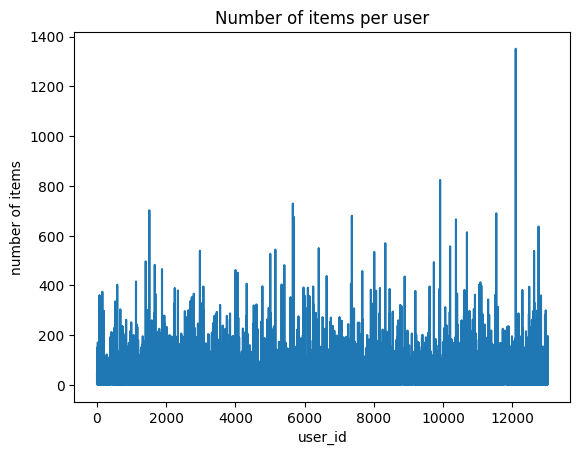

In [17]:
train_data.groupby('row').count().col.plot()
plt.xlabel('user_id')
plt.ylabel('number of items')
plt.title('Number of items per user');

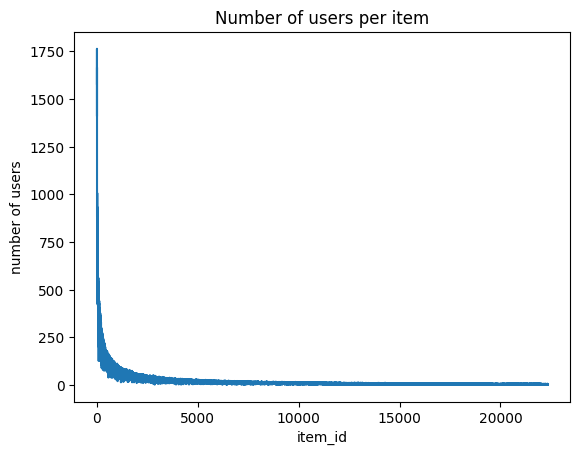

In [18]:
train_data.groupby('col').count().row.plot()
plt.xlabel('item_id')
plt.ylabel('number of users')
plt.title('Number of users per item');

In [19]:
URM_all = sps.csr_matrix((train_data.data.values,
                          ((train_data.row - 1).values, (train_data.col - 1).values)),
                        shape=(train_data.row.max(), train_data.col.max()))
URM_all

<13024x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

# Cross Validation Split

In [20]:
%cd /kaggle/working/Recsys_Challenge_2023

/kaggle/working/Recsys_Challenge_2023


In [21]:
from Data_manager.IncrementalSparseMatrix import IncrementalSparseMatrix


class CrossValidationSplitter:
    def __init__(self, n_splits):
        self.n_splits = n_splits
        self.folds = []
        
    def split(self, URM):
        n_int_per_split = int(URM.nnz / self.n_splits)
        indices = np.arange(0, URM.nnz, 1)
        np.random.shuffle(indices)
        num_users, num_items = URM.shape
        
        URM_all = sps.coo_matrix(URM)
        
        for i in range(self.n_splits):
            if i == self.n_splits - 1:
                indices_valid = indices[n_int_per_split * i:]
                indices_train = indices[:n_int_per_split * i]
            else:
                indices_valid = indices[n_int_per_split * i: n_int_per_split * (i + 1)]
                indices_train_1 = indices[n_int_per_split * max(0, i - 1): n_int_per_split * i]
                indices_train_2 = indices[n_int_per_split * (i + 1):]
                indices_train = np.concatenate((indices_train_1, indices_train_2))
                
            URM_valid_builder = IncrementalSparseMatrix(
                n_rows=num_users, n_cols=num_items, auto_create_col_mapper=False, 
                auto_create_row_mapper=False
            )
            
            URM_train_builder = IncrementalSparseMatrix(
                n_rows=num_users, n_cols=num_items, auto_create_col_mapper=False, 
                auto_create_row_mapper=False
            )
            
            URM_valid_builder.add_data_lists(
                URM_all.row[indices_valid],
                URM_all.col[indices_valid],
                URM_all.data[indices_valid]
            )
            
            URM_train_builder.add_data_lists(
                URM_all.row[indices_train],
                URM_all.col[indices_train],
                URM_all.data[indices_train]
            )
            
            yield URM_train_builder.get_SparseMatrix(), URM_valid_builder.get_SparseMatrix()

# Experiments

In [22]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

In [23]:
URM_train, URM_test_complete = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_validation, URM_test = split_train_in_two_percentage_global_sample(URM_test_complete, train_percentage = 0.8)

# Hyperparameters tuning

In [24]:
import sqlite3

def print_all_rows(table_name, database_path):
    # Connect to the SQLite database
    connection = sqlite3.connect(database_path)

    # Create a cursor object to execute SQL queries
    cursor = connection.cursor()

    try:
        # Fetch all rows from the specified table
        cursor.execute(f"SELECT * FROM {table_name};")

        # Fetch all rows
        rows = cursor.fetchall()

        # Print the rows
        print(f"All rows from table '{table_name}':")
        for row in rows:
            print(row)

    except sqlite3.Error as e:
        print(f"Error reading data from table '{table_name}': {e}")

    finally:
        # Close the cursor and connection
        cursor.close()
        connection.close()

# Replace 'your_table_name' with the actual table name you want to print
table_name = 'studies'
print_all_rows(table_name, config['database_path'])

All rows from table 'studies':
(1, 'hyperparameters_tuning_knn_item')


Not considering adjusted cosine and pearson since they remove the mean of the interactions, but here there are all interactions equal to 1

## Item KNN Collaborative Filtering

In [25]:
from concurrent.futures import ThreadPoolExecutor

def evaluate_item_knn(URM_train, URM_valid, params):
    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(**params)

    evaluator = EvaluatorHoldout(URM_valid, cutoff_list=[10])
    result_df, _ = evaluator.evaluateRecommender(recommender)
    print(f'MAP is {result_df.loc[10, "MAP"]}')
    return result_df.loc[10, 'MAP']


def objective_item_knn(trial):
    params = {
        'topK': trial.suggest_int('topK', 10, 1000),
        'shrink': trial.suggest_int('shrink', 0, 500),
        'similarity': trial.suggest_categorical('similarity', ["cosine", "asymmetric", "dice", "jaccard", "tanimoto", "tversky", "euclidean"]),        
    }
    
    if params['similarity'] == "asymmetric":
        params["asymmetric_alpha"] = trial.suggest_float("asymmetric_alpha", 0, 2, log=False)
        params["normalize"] = True     

    elif params['similarity'] == "tversky":
        params["tversky_alpha"] = trial.suggest_float("tversky_alpha", 0, 2, log=False)
        params["tversky_beta"] = trial.suggest_float("tversky_beta", 0, 2, log=False)
        params["normalize"] = True 

    elif params['similarity'] == "euclidean":
        params["normalize_avg_row"] = trial.suggest_categorical("normalize_avg_row", [True, False])
        params["similarity_from_distance_mode"] = trial.suggest_categorical("similarity_from_distance_mode", ["lin", "log", "exp"])
        params["normalize"] = trial.suggest_categorical("normalize", [True, False])
    
    results = [None] * 10
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = []
        for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
            futures.append(executor.submit(evaluate_item_knn, URM_train, URM_valid, params))
        print(len(futures))
        for j, future in enumerate(futures):
            results[j] = future.result()
        
    return np.mean(results)

In [26]:
%%time

if config['tune_parameters_item_knn']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_knn_item', 
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_item_knn, n_trials=100)

[I 2023-11-23 23:25:56,503] Using an existing study with name 'hyperparameters_tuning_knn_item' instead of creating a new one.


ItemKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 597 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 235 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 767 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 925 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 568 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1151 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 864 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1441 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-23 23:28:26,147] Trial 100 finished with value: 0.01586195046226209 and parameters: {'topK': 207, 'shrink': 4, 'similarity': 'tversky', 'tversky_alpha': 0.3818913707444288, 'tversky_beta': 1.8743874919859789}. Best is trial 53 with value: 0.019041961457624816.


ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 612 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 239 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 749 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 348 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 943 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 542 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1138 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 832 ( 3.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1455 (11.2%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-23 23:30:57,933] Trial 101 finished with value: 0.018618316022681963 and parameters: {'topK': 30, 'shrink': 19, 'similarity': 'tversky', 'tversky_alpha': 0.5727683908054909, 'tversky_beta': 1.7798090163714468}. Best is trial 53 with value: 0.019041961457624816.


MAP is 0.02700361617147684
MAP is 0.027913329422847962
ItemKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 498 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 777 ( 6.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 344 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 512 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1164 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 858 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1458 (11.

[I 2023-11-23 23:33:25,711] Trial 102 finished with value: 0.018348120133037122 and parameters: {'topK': 32, 'shrink': 17, 'similarity': 'tversky', 'tversky_alpha': 0.4416208622623554, 'tversky_beta': 1.7791930455902123}. Best is trial 53 with value: 0.019041961457624816.


MAP is 0.026287688077558446
MAP is 0.026612117494862357
ItemKNNCFRecommender: URM Detected 473 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 604 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 226 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 740 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 914 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 533 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1152 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 865 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1463 (11

[I 2023-11-23 23:35:57,814] Trial 103 finished with value: 0.01856883873592569 and parameters: {'topK': 35, 'shrink': 19, 'similarity': 'tversky', 'tversky_alpha': 0.40981588612735825, 'tversky_beta': 1.7483886703031668}. Best is trial 53 with value: 0.019041961457624816.


ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 607 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 222 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 332 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 936 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 508 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1126 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 846 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1460 (11.2%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-23 23:38:25,301] Trial 104 finished with value: 0.018538899368908835 and parameters: {'topK': 32, 'shrink': 15, 'similarity': 'tversky', 'tversky_alpha': 0.3246360997479356, 'tversky_beta': 1.6750699167979317}. Best is trial 53 with value: 0.019041961457624816.


MAP is 0.027162421864025867
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 161 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 503 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 589 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 220 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 767 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 352 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 534 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1168 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 884 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1409 (10.8%) users with no interacti

[I 2023-11-23 23:40:55,790] Trial 105 finished with value: 0.016411357855558896 and parameters: {'topK': 29, 'shrink': 0, 'similarity': 'tversky', 'tversky_alpha': 0.303690436598932, 'tversky_beta': 1.6501706689681315}. Best is trial 53 with value: 0.019041961457624816.


MAP is 0.027463487714720587
ItemKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 593 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 232 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 358 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 922 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 531 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1162 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 866 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1417 (10.9%) users with no interacti

[I 2023-11-23 23:43:29,588] Trial 106 finished with value: 0.016960890923328503 and parameters: {'topK': 109, 'shrink': 23, 'similarity': 'tversky', 'tversky_alpha': 0.28158176477363017, 'tversky_beta': 1.7441818338706807}. Best is trial 53 with value: 0.019041961457624816.


ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 738 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 361 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 927 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 558 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1154 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 913 ( 4.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1445 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-23 23:46:06,536] Trial 107 finished with value: 0.018330102584153192 and parameters: {'topK': 32, 'shrink': 12, 'similarity': 'tversky', 'tversky_alpha': 0.41650138858267605, 'tversky_beta': 1.7662222537183916}. Best is trial 53 with value: 0.019041961457624816.


MAP is 0.02718387734600485
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 755 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 362 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 896 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 565 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1157 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 869 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1413 (10.8%) users with no interactio

[I 2023-11-23 23:48:41,460] Trial 108 finished with value: 0.014543734057171808 and parameters: {'topK': 794, 'shrink': 36, 'similarity': 'tversky', 'tversky_alpha': 0.38118193246231236, 'tversky_beta': 1.6145893718013573}. Best is trial 53 with value: 0.019041961457624816.


MAP is 0.015870294759460567
ItemKNNCFRecommender: URM Detected 510 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 193 ( 0.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 628 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 773 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 383 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 934 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 556 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1155 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 930 ( 4.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1473 (11.3%) users with no interacti

[I 2023-11-23 23:51:14,605] Trial 109 finished with value: 0.01689053599890792 and parameters: {'topK': 148, 'shrink': 8, 'similarity': 'tversky', 'tversky_alpha': 0.42280097316505766, 'tversky_beta': 1.751805035428608}. Best is trial 53 with value: 0.019041961457624816.


MAP is 0.024502144197266183
MAP is 0.024619389116553925
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 475 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 593 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 742 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 347 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1112 ( 8.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 861 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1449 (11

[I 2023-11-23 23:53:45,373] Trial 110 finished with value: 0.014260342571091753 and parameters: {'topK': 91, 'shrink': 374, 'similarity': 'tversky', 'tversky_alpha': 0.20657421618197108, 'tversky_beta': 1.9024619772255762}. Best is trial 53 with value: 0.019041961457624816.


MAP is 0.01971081206194305
ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 464 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 731 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 558 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1149 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 865 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1437 (11.0%) users with no interactio

[I 2023-11-23 23:56:17,845] Trial 111 finished with value: 0.018648883190346924 and parameters: {'topK': 31, 'shrink': 16, 'similarity': 'tversky', 'tversky_alpha': 0.4436521261261532, 'tversky_beta': 1.7829067538833525}. Best is trial 53 with value: 0.019041961457624816.


ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 589 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 725 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 379 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1097 ( 8.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 904 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1405 (10.8%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-23 23:58:51,850] Trial 112 finished with value: 0.018348781391660948 and parameters: {'topK': 28, 'shrink': 10, 'similarity': 'tversky', 'tversky_alpha': 0.44243335526601146, 'tversky_beta': 1.749508219536168}. Best is trial 53 with value: 0.019041961457624816.


ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 600 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 226 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 744 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 352 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 911 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 569 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1116 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 892 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1454 (11.2%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 00:01:30,812] Trial 113 finished with value: 0.017866060949257134 and parameters: {'topK': 56, 'shrink': 33, 'similarity': 'tversky', 'tversky_alpha': 0.43500489204411386, 'tversky_beta': 1.6644305837307038}. Best is trial 53 with value: 0.019041961457624816.


MAP is 0.02512327813888758
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 734 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 344 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 547 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1167 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1399 (10.7%) users with no interactio

[I 2023-11-24 00:04:03,622] Trial 114 finished with value: 0.01835857095960397 and parameters: {'topK': 29, 'shrink': 9, 'similarity': 'tversky', 'tversky_alpha': 0.3442317064303025, 'tversky_beta': 1.7585539657953655}. Best is trial 53 with value: 0.019041961457624816.


MAP is 0.026793593759597147
ItemKNNCFRecommender: URM Detected 472 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 185 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 157 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 577 ( 4.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 266 ( 1.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 714 ( 5.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 344 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 561 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1100 ( 8.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 853 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1370 (10.5%) users with no interacti

[I 2023-11-24 00:06:38,042] Trial 115 finished with value: 0.017267287721983573 and parameters: {'topK': 76, 'shrink': 33, 'similarity': 'tversky', 'tversky_alpha': 0.2884144357520236, 'tversky_beta': 1.7488723746340262}. Best is trial 53 with value: 0.019041961457624816.


ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 504 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 581 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 759 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 348 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 918 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1136 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 883 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1431 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 00:09:13,119] Trial 116 finished with value: 0.015970885101482268 and parameters: {'topK': 55, 'shrink': 0, 'similarity': 'tversky', 'tversky_alpha': 0.4199449540359555, 'tversky_beta': 1.6156418822608392}. Best is trial 53 with value: 0.019041961457624816.


MAP is 0.025897343110012246
ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 596 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 246 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 750 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 363 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 907 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 544 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1142 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 895 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1431 (11.0%) users with no interacti

[I 2023-11-24 00:11:46,211] Trial 117 finished with value: 0.018774879869418983 and parameters: {'topK': 30, 'shrink': 20, 'similarity': 'tversky', 'tversky_alpha': 0.3325254560423018, 'tversky_beta': 1.9178632228983665}. Best is trial 53 with value: 0.019041961457624816.


ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 613 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 739 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 366 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 896 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 580 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1147 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 930 ( 4.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1444 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 00:19:09,801] Trial 118 finished with value: 0.00797538304514 and parameters: {'topK': 405, 'shrink': 21, 'similarity': 'euclidean', 'normalize_avg_row': True, 'similarity_from_distance_mode': 'exp', 'normalize': True}. Best is trial 53 with value: 0.019041961457624816.


MAP is 0.0029477307029176724
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 499 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 604 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 244 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 743 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 359 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 914 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 563 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1120 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 884 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1448 (11.1%) users with no interact

[I 2023-11-24 00:21:40,083] Trial 119 finished with value: 0.016859681160923613 and parameters: {'topK': 112, 'shrink': 8, 'similarity': 'tversky', 'tversky_alpha': 0.32483300392750547, 'tversky_beta': 1.9310395071170738}. Best is trial 53 with value: 0.019041961457624816.


ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 756 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 339 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 949 ( 7.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 517 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1141 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 864 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1470 (11.3%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 00:24:12,707] Trial 120 finished with value: 0.016424604652591508 and parameters: {'topK': 91, 'shrink': 37, 'similarity': 'cosine'}. Best is trial 53 with value: 0.019041961457624816.


MAP is 0.023306692354456277
ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 183 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 245 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 742 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 362 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 933 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 573 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1152 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 860 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1461 (11.2%) users with no interacti

[I 2023-11-24 00:26:47,401] Trial 121 finished with value: 0.018424847586572694 and parameters: {'topK': 33, 'shrink': 23, 'similarity': 'tversky', 'tversky_alpha': 0.449318239068447, 'tversky_beta': 1.7680507839439794}. Best is trial 53 with value: 0.019041961457624816.


ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 484 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 575 ( 4.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 256 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 730 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 349 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 885 ( 6.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 548 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1086 ( 8.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 892 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1422 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 00:29:22,548] Trial 122 finished with value: 0.01811540651731441 and parameters: {'topK': 54, 'shrink': 22, 'similarity': 'tversky', 'tversky_alpha': 0.40094036130584093, 'tversky_beta': 1.9130585359441064}. Best is trial 53 with value: 0.019041961457624816.


MAP is 0.025949239564441087
ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 228 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 737 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 364 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 912 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 521 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1129 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 862 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1438 (11.0%) users with no interacti

[I 2023-11-24 00:31:57,796] Trial 123 finished with value: 0.01829203532664601 and parameters: {'topK': 34, 'shrink': 10, 'similarity': 'tversky', 'tversky_alpha': 0.22249056933329636, 'tversky_beta': 1.5375439268616584}. Best is trial 53 with value: 0.019041961457624816.


ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 622 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 246 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 750 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 342 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 933 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 560 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1162 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 847 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1409 (10.8%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 00:34:32,554] Trial 124 finished with value: 0.01697232207131363 and parameters: {'topK': 79, 'shrink': 28, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.1613684036287215}. Best is trial 53 with value: 0.019041961457624816.


MAP is 0.02387600095550748
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 599 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 253 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 729 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 893 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 560 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1128 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 850 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1441 (11.1%) users with no interactio

[I 2023-11-24 00:37:09,590] Trial 125 finished with value: 0.019054370200979536 and parameters: {'topK': 11, 'shrink': 39, 'similarity': 'tversky', 'tversky_alpha': 0.4367118732669021, 'tversky_beta': 1.7510751150088335}. Best is trial 125 with value: 0.019054370200979536.


ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 613 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 747 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 935 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 507 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1156 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 848 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1426 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 00:39:47,460] Trial 126 finished with value: 0.019172636095484207 and parameters: {'topK': 15, 'shrink': 41, 'similarity': 'tversky', 'tversky_alpha': 0.3297883089474941, 'tversky_beta': 1.9244729524011221}. Best is trial 126 with value: 0.019172636095484207.


MAP is 0.02731446502773123
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 611 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 743 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 354 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 908 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1131 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 860 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1436 (11.0%) users with no interactio

[I 2023-11-24 00:42:26,188] Trial 127 finished with value: 0.017718877209576944 and parameters: {'topK': 10, 'shrink': 40, 'similarity': 'dice'}. Best is trial 126 with value: 0.019172636095484207.


MAP is 0.02521997093747856
MAP is 0.025126520533581023
ItemKNNCFRecommender: URM Detected 481 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 724 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 367 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 912 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 560 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1112 ( 8.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 858 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1431 (11.

[I 2023-11-24 00:45:01,229] Trial 128 finished with value: 0.016948773087828457 and parameters: {'topK': 65, 'shrink': 68, 'similarity': 'tversky', 'tversky_alpha': 0.28688744298623575, 'tversky_beta': 1.68616861372707}. Best is trial 126 with value: 0.019172636095484207.


MAP is 0.02328071131672471
MAP is 0.01804609205223962
MAP is 0.021660864635160836
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 504 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 759 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 340 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 926 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 527 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1130 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 849 ( 3.8%) items with no interactions.
ItemKNNCFRecommen

[I 2023-11-24 00:47:38,902] Trial 129 finished with value: 0.016299036831478153 and parameters: {'topK': 127, 'shrink': 51, 'similarity': 'tversky', 'tversky_alpha': 0.34751832572432473, 'tversky_beta': 1.9181991467057187}. Best is trial 126 with value: 0.019172636095484207.


MAP is 0.020166298409872434
MAP is 0.022516360230007124
ItemKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 603 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 235 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 728 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 328 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 889 ( 6.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 521 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1136 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 879 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1431 (11

[I 2023-11-24 00:50:14,839] Trial 130 finished with value: 0.017924846279104057 and parameters: {'topK': 53, 'shrink': 41, 'similarity': 'tversky', 'tversky_alpha': 0.3444370115686859, 'tversky_beta': 1.9803001591591598}. Best is trial 126 with value: 0.019172636095484207.


MAP is 0.02494835677029667
MAP is 0.025602343310607192
ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 589 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 252 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 712 ( 5.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 350 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 887 ( 6.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 544 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1108 ( 8.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 888 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1379 (10.

[I 2023-11-24 00:52:48,654] Trial 131 finished with value: 0.01866087631085283 and parameters: {'topK': 25, 'shrink': 20, 'similarity': 'tversky', 'tversky_alpha': 0.4478699265436591, 'tversky_beta': 1.766109597225711}. Best is trial 126 with value: 0.019172636095484207.


MAP is 0.02749989436768497
MAP is 0.02703777393767403
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 161 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 472 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 621 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 732 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 347 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 931 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 554 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1131 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 846 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1469 (11.3

[I 2023-11-24 00:55:19,761] Trial 132 finished with value: 0.019026052269000816 and parameters: {'topK': 12, 'shrink': 29, 'similarity': 'tversky', 'tversky_alpha': 0.4333805293810843, 'tversky_beta': 1.7631642950973525}. Best is trial 126 with value: 0.019172636095484207.


ItemKNNCFRecommender: URM Detected 506 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 181 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 617 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 253 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 772 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 339 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 925 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 541 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1148 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 848 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1440 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 00:57:47,057] Trial 133 finished with value: 0.019109016978548988 and parameters: {'topK': 14, 'shrink': 32, 'similarity': 'tversky', 'tversky_alpha': 0.33694542768142544, 'tversky_beta': 1.6992431262593706}. Best is trial 126 with value: 0.019172636095484207.


MAP is 0.027802509702321756
ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 603 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 752 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 346 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 544 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1155 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 851 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1434 (11.0%) users with no interacti

[I 2023-11-24 01:00:24,179] Trial 134 finished with value: 0.019088721220164598 and parameters: {'topK': 10, 'shrink': 28, 'similarity': 'tversky', 'tversky_alpha': 0.2311363781411145, 'tversky_beta': 1.6875524680022027}. Best is trial 126 with value: 0.019172636095484207.


ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 584 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 235 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 774 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 360 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 929 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 525 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1143 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 845 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1456 (11.2%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 01:03:05,610] Trial 135 finished with value: 0.017799765062410714 and parameters: {'topK': 14, 'shrink': 30, 'similarity': 'jaccard'}. Best is trial 126 with value: 0.019172636095484207.


ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 612 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 346 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 921 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 570 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1164 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 855 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1475 (11.3%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 01:05:43,994] Trial 136 finished with value: 0.017745666081260356 and parameters: {'topK': 56, 'shrink': 39, 'similarity': 'tversky', 'tversky_alpha': 0.14300262007100267, 'tversky_beta': 1.6858182405284101}. Best is trial 126 with value: 0.019172636095484207.


ItemKNNCFRecommender: URM Detected 472 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 507 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 587 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 234 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 741 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 328 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 913 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 496 ( 2.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1122 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 833 ( 3.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1424 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 01:08:11,845] Trial 137 finished with value: 0.016775889541434812 and parameters: {'topK': 11, 'shrink': 330, 'similarity': 'tversky', 'tversky_alpha': 0.24216349393146913, 'tversky_beta': 1.9281730002627921}. Best is trial 126 with value: 0.019172636095484207.


ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 249 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 714 ( 5.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 342 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 900 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 546 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1130 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1425 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 01:10:38,131] Trial 138 finished with value: 0.015433844960696066 and parameters: {'topK': 552, 'shrink': 57, 'similarity': 'tversky', 'tversky_alpha': 0.6101999634785168, 'tversky_beta': 1.6370362260465474}. Best is trial 126 with value: 0.019172636095484207.


MAP is 0.019067755541909617
ItemKNNCFRecommender: URM Detected 481 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 192 ( 0.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 753 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 389 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 920 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 555 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1195 ( 9.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 896 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1443 (11.1%) users with no interacti

[I 2023-11-24 01:13:01,714] Trial 139 finished with value: 0.017451785127036483 and parameters: {'topK': 82, 'shrink': 26, 'similarity': 'tversky', 'tversky_alpha': 0.4773288590146106, 'tversky_beta': 1.5550171776691477}. Best is trial 126 with value: 0.019172636095484207.


MAP is 0.014587758428185065
MAP is 0.017064765229869945
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 184 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 596 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 261 ( 1.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 741 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 375 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 904 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 550 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1113 ( 8.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 889 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1456 (11

[I 2023-11-24 01:18:32,583] Trial 140 finished with value: 0.01126125191265143 and parameters: {'topK': 53, 'shrink': 0, 'similarity': 'euclidean', 'normalize_avg_row': False, 'similarity_from_distance_mode': 'exp', 'normalize': True}. Best is trial 126 with value: 0.019172636095484207.


MAP is 0.0035438549609568856
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 588 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 757 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 325 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 899 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 537 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1149 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 837 ( 3.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1446 (11.1%) users with no interact

[I 2023-11-24 01:21:03,594] Trial 141 finished with value: 0.018852075269999 and parameters: {'topK': 10, 'shrink': 48, 'similarity': 'tversky', 'tversky_alpha': 0.34031314976102295, 'tversky_beta': 1.7155050028669527}. Best is trial 126 with value: 0.019172636095484207.


MAP is 0.026412093197807508
ItemKNNCFRecommender: URM Detected 471 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 597 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 249 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 742 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 343 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 927 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 537 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1154 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 899 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1461 (11.2%) users with no interacti

[I 2023-11-24 01:23:32,748] Trial 142 finished with value: 0.01790948012450208 and parameters: {'topK': 42, 'shrink': 47, 'similarity': 'tversky', 'tversky_alpha': 0.3319518954163885, 'tversky_beta': 1.7014766200896387}. Best is trial 126 with value: 0.019172636095484207.


MAP is 0.019665458518798494
ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 619 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 258 ( 1.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 733 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 935 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 546 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1136 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 883 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1429 (11.0%) users with no interacti

[I 2023-11-24 01:25:58,843] Trial 143 finished with value: 0.01879131046962963 and parameters: {'topK': 22, 'shrink': 34, 'similarity': 'tversky', 'tversky_alpha': 0.3943230230872453, 'tversky_beta': 1.7790318620126992}. Best is trial 126 with value: 0.019172636095484207.


MAP is 0.026365170791400314
ItemKNNCFRecommender: URM Detected 471 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 600 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 724 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 377 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 911 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 536 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1153 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 943 ( 4.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1424 (10.9%) users with no interacti

[I 2023-11-24 01:28:37,031] Trial 144 finished with value: 0.018489363228261106 and parameters: {'topK': 15, 'shrink': 66, 'similarity': 'tversky', 'tversky_alpha': 0.3641983775597817, 'tversky_beta': 1.6868527254708179}. Best is trial 126 with value: 0.019172636095484207.


MAP is 0.02639024310628356
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 234 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 734 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 380 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 923 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 547 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1137 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 895 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1430 (11.0%) users with no interactio

[I 2023-11-24 01:31:20,709] Trial 145 finished with value: 0.018391205403137666 and parameters: {'topK': 17, 'shrink': 64, 'similarity': 'tversky', 'tversky_alpha': 0.3779831067776317, 'tversky_beta': 1.684079528848061}. Best is trial 126 with value: 0.019172636095484207.


MAP is 0.025759068531507997
ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 617 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 729 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 923 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 517 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1115 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 895 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1421 (10.9%) users with no interacti

[I 2023-11-24 01:33:51,175] Trial 146 finished with value: 0.01651883441797666 and parameters: {'topK': 70, 'shrink': 79, 'similarity': 'tversky', 'tversky_alpha': 0.2435042762350716, 'tversky_beta': 1.6203012327061481}. Best is trial 126 with value: 0.019172636095484207.


ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 648 ( 5.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 244 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 766 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 362 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 949 ( 7.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 556 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1183 ( 9.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 871 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1471 (11.3%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 01:36:17,904] Trial 147 finished with value: 0.016937813627750826 and parameters: {'topK': 14, 'shrink': 52, 'similarity': 'cosine'}. Best is trial 126 with value: 0.019172636095484207.


MAP is 0.023132682650265392
MAP is 0.0242610248022533
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 186 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 624 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 737 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 360 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 554 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1139 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 892 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1421 (10.9

[I 2023-11-24 01:38:41,341] Trial 148 finished with value: 0.018084225792371306 and parameters: {'topK': 49, 'shrink': 35, 'similarity': 'tversky', 'tversky_alpha': 0.35843517349979326, 'tversky_beta': 1.8875908807738704}. Best is trial 126 with value: 0.019172636095484207.


MAP is 0.025706735496558566
ItemKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 621 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 757 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 378 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 531 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1163 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 900 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1455 (11.2%) users with no interacti

[I 2023-11-24 01:41:10,421] Trial 149 finished with value: 0.013594162253977391 and parameters: {'topK': 89, 'shrink': 215, 'similarity': 'asymmetric', 'asymmetric_alpha': 1.2811646470261722}. Best is trial 126 with value: 0.019172636095484207.


MAP is 0.018036932203598786
ItemKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 498 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 586 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 740 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 346 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 513 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1137 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 876 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1410 (10.8%) users with no interacti

[I 2023-11-24 01:43:45,670] Trial 150 finished with value: 0.010919952524042098 and parameters: {'topK': 942, 'shrink': 472, 'similarity': 'tversky', 'tversky_alpha': 0.27519851824749203, 'tversky_beta': 1.791500824602567}. Best is trial 126 with value: 0.019172636095484207.


MAP is 0.014452091807140027
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 719 ( 5.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 350 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 912 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 536 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1124 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 863 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1391 (10.7%) users with no interacti

[I 2023-11-24 01:46:16,045] Trial 151 finished with value: 0.01900770962114879 and parameters: {'topK': 12, 'shrink': 30, 'similarity': 'tversky', 'tversky_alpha': 0.43760412889057315, 'tversky_beta': 1.7160286524988033}. Best is trial 126 with value: 0.019172636095484207.


ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 758 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 358 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 927 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 529 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1165 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1450 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 01:48:41,199] Trial 152 finished with value: 0.018846027806224172 and parameters: {'topK': 14, 'shrink': 43, 'similarity': 'tversky', 'tversky_alpha': 0.37762630092627036, 'tversky_beta': 1.7156359174124576}. Best is trial 126 with value: 0.019172636095484207.


MAP is 0.020104199122996935
MAP is 0.02760685824786252
ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 475 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 187 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 607 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 239 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 752 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 367 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 915 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 570 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1145 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 905 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1446 (11.

[I 2023-11-24 01:51:09,269] Trial 153 finished with value: 0.01893262152584379 and parameters: {'topK': 10, 'shrink': 43, 'similarity': 'tversky', 'tversky_alpha': 0.4349566026227095, 'tversky_beta': 1.7311018045397257}. Best is trial 126 with value: 0.019172636095484207.


ItemKNNCFRecommender: URM Detected 501 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 231 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 758 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 353 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 922 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 549 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1161 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 848 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1438 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 01:53:41,630] Trial 154 finished with value: 0.01783548144914772 and parameters: {'topK': 51, 'shrink': 45, 'similarity': 'tversky', 'tversky_alpha': 0.4763271131215528, 'tversky_beta': 1.800612347246162}. Best is trial 126 with value: 0.019172636095484207.


MAP is 0.025069871185724842
ItemKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 727 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 359 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 928 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 519 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1135 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 865 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1463 (11.2%) users with no interacti

[I 2023-11-24 01:56:11,447] Trial 155 finished with value: 0.017691257017259755 and parameters: {'topK': 13, 'shrink': 32, 'similarity': 'dice'}. Best is trial 126 with value: 0.019172636095484207.


MAP is 0.022458416526621006
MAP is 0.026256025409533618
ItemKNNCFRecommender: URM Detected 505 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 469 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 635 ( 4.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 245 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 939 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 548 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1171 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 908 ( 4.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1445 (11

[I 2023-11-24 01:58:42,836] Trial 156 finished with value: 0.017530933649817886 and parameters: {'topK': 63, 'shrink': 57, 'similarity': 'tversky', 'tversky_alpha': 0.40659869821071243, 'tversky_beta': 1.9907576596514884}. Best is trial 126 with value: 0.019172636095484207.


ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 592 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 250 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 736 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 929 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 558 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1160 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 891 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1427 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 02:01:16,215] Trial 157 finished with value: 0.01826673541345396 and parameters: {'topK': 43, 'shrink': 37, 'similarity': 'tversky', 'tversky_alpha': 0.47077485316775625, 'tversky_beta': 1.726196273643425}. Best is trial 126 with value: 0.019172636095484207.


ItemKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 182 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 633 ( 4.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 258 ( 1.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 751 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 349 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 926 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 533 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1164 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 859 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1449 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 02:03:42,426] Trial 158 finished with value: 0.019211553512315137 and parameters: {'topK': 10, 'shrink': 26, 'similarity': 'tversky', 'tversky_alpha': 0.4049309794671737, 'tversky_beta': 1.8709409033985953}. Best is trial 158 with value: 0.019211553512315137.


ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 752 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 916 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 551 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1139 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 851 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1407 (10.8%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 02:06:04,917] Trial 159 finished with value: 0.018996228528371847 and parameters: {'topK': 13, 'shrink': 51, 'similarity': 'tversky', 'tversky_alpha': 0.15733611526198538, 'tversky_beta': 1.8779368163637873}. Best is trial 158 with value: 0.019211553512315137.


MAP is 0.027163478429583443
MAP is 0.02748297440107786
ItemKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 628 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 759 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 328 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 929 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1170 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1453 (11.

[I 2023-11-24 02:08:31,691] Trial 160 finished with value: 0.019043704329127407 and parameters: {'topK': 15, 'shrink': 47, 'similarity': 'tversky', 'tversky_alpha': 0.08885487026417593, 'tversky_beta': 1.9527720492857021}. Best is trial 158 with value: 0.019211553512315137.


ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 599 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 746 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 347 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 558 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1161 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 882 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1428 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 02:10:58,244] Trial 161 finished with value: 0.019082365421670744 and parameters: {'topK': 11, 'shrink': 50, 'similarity': 'tversky', 'tversky_alpha': 0.15586180847034953, 'tversky_beta': 1.8758876061862528}. Best is trial 158 with value: 0.019211553512315137.


MAP is 0.027314204808136875
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 604 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 244 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 730 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 369 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 926 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 577 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1154 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 879 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1418 (10.9%) users with no interacti

[I 2023-11-24 02:13:27,149] Trial 162 finished with value: 0.018705419745376158 and parameters: {'topK': 14, 'shrink': 71, 'similarity': 'tversky', 'tversky_alpha': 0.13991724776742748, 'tversky_beta': 1.8828085655219022}. Best is trial 158 with value: 0.019211553512315137.


MAP is 0.01766712005563918
MAP is 0.027168253086909417
MAP is 0.025900350069534336
ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 612 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 759 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 339 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 899 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 561 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1153 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 851 ( 3.8%) items with no interactions.
ItemKNNCFRecomme

[I 2023-11-24 02:15:54,007] Trial 163 finished with value: 0.01870493683354973 and parameters: {'topK': 10, 'shrink': 75, 'similarity': 'tversky', 'tversky_alpha': 0.1464745493585648, 'tversky_beta': 1.873662840884859}. Best is trial 158 with value: 0.019211553512315137.


MAP is 0.027160773430729843
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 600 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 258 ( 1.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 779 ( 6.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 355 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 914 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 562 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1175 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 896 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1462 (11.2%) users with no interacti

[I 2023-11-24 02:18:14,255] Trial 164 finished with value: 0.019101186527583032 and parameters: {'topK': 10, 'shrink': 48, 'similarity': 'tversky', 'tversky_alpha': 0.09778167847678068, 'tversky_beta': 1.8853600460210536}. Best is trial 158 with value: 0.019211553512315137.


ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 475 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 727 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 357 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 924 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 561 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1121 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 854 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1413 (10.8%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 02:20:37,043] Trial 165 finished with value: 0.017628335979772904 and parameters: {'topK': 67, 'shrink': 51, 'similarity': 'tversky', 'tversky_alpha': 0.07188928170371088, 'tversky_beta': 1.954399841401713}. Best is trial 158 with value: 0.019211553512315137.


ItemKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 631 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 227 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 735 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 922 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 532 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1153 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 864 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1459 (11.2%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 02:23:10,288] Trial 166 finished with value: 0.017573864852769086 and parameters: {'topK': 10, 'shrink': 61, 'similarity': 'jaccard'}. Best is trial 158 with value: 0.019211553512315137.


MAP is 0.02532930460906387
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 613 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 742 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 925 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 555 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1164 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 887 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1419 (10.9%) users with no interactio

[I 2023-11-24 02:25:36,145] Trial 167 finished with value: 0.017851572064119074 and parameters: {'topK': 50, 'shrink': 46, 'similarity': 'tversky', 'tversky_alpha': 0.18023823164155553, 'tversky_beta': 1.947353526688602}. Best is trial 158 with value: 0.019211553512315137.


MAP is 0.025582979953399695
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 741 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 960 ( 7.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 553 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1130 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 821 ( 3.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1438 (11.0%) users with no interacti

[I 2023-11-24 02:28:00,608] Trial 168 finished with value: 0.018492022721706573 and parameters: {'topK': 40, 'shrink': 42, 'similarity': 'tversky', 'tversky_alpha': 0.05198569347708272, 'tversky_beta': 1.8653228172707341}. Best is trial 158 with value: 0.019211553512315137.


MAP is 0.02276062295947717
MAP is 0.025486788265118354
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 620 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 738 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 357 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 534 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1169 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 860 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1436 (11.

[I 2023-11-24 02:30:29,203] Trial 169 finished with value: 0.017318505218542602 and parameters: {'topK': 71, 'shrink': 55, 'similarity': 'tversky', 'tversky_alpha': 0.08724536230148812, 'tversky_beta': 1.9552279075555012}. Best is trial 158 with value: 0.019211553512315137.


MAP is 0.023665937237365802
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 577 ( 4.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 248 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 774 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 345 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1170 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 860 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1446 (11.1%) users with no interacti

[I 2023-11-24 02:33:03,850] Trial 170 finished with value: 0.017138237368352686 and parameters: {'topK': 11, 'shrink': 246, 'similarity': 'tversky', 'tversky_alpha': 0.20435400257295133, 'tversky_beta': 1.8385635852560405}. Best is trial 158 with value: 0.019211553512315137.


MAP is 0.023822593887388117
MAP is 0.023664745500080395
ItemKNNCFRecommender: URM Detected 502 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 484 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 616 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 769 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 940 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 542 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1168 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 849 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1469 (11

[I 2023-11-24 02:35:36,073] Trial 171 finished with value: 0.018535715527672216 and parameters: {'topK': 26, 'shrink': 70, 'similarity': 'tversky', 'tversky_alpha': 0.11495243850468112, 'tversky_beta': 1.8971802777002305}. Best is trial 158 with value: 0.019211553512315137.


ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 188 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 610 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 749 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 375 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 890 ( 6.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 574 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1179 ( 9.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 857 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1423 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 02:37:53,664] Trial 172 finished with value: 0.018225564963390357 and parameters: {'topK': 47, 'shrink': 31, 'similarity': 'tversky', 'tversky_alpha': 0.16359712830600032, 'tversky_beta': 1.998246468625387}. Best is trial 158 with value: 0.019211553512315137.


ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 583 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 737 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 357 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 902 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 548 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1109 ( 8.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 858 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1420 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 02:40:18,877] Trial 173 finished with value: 0.012262914364096504 and parameters: {'topK': 459, 'shrink': 82, 'similarity': 'tversky', 'tversky_alpha': 0.03784284434270127, 'tversky_beta': 1.8711893277447431}. Best is trial 158 with value: 0.019211553512315137.


ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 506 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 227 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 363 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 921 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1129 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 887 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1473 (11.3%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 02:42:42,890] Trial 174 finished with value: 0.019174608763344307 and parameters: {'topK': 11, 'shrink': 48, 'similarity': 'tversky', 'tversky_alpha': 0.2317090056660552, 'tversky_beta': 1.8209607734724778}. Best is trial 158 with value: 0.019211553512315137.


ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 181 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 602 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 231 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 740 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 353 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 929 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 533 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1119 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 887 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1409 (10.8%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 02:45:13,012] Trial 175 finished with value: 0.018249666076536688 and parameters: {'topK': 41, 'shrink': 41, 'similarity': 'tversky', 'tversky_alpha': 0.2541310887230456, 'tversky_beta': 1.8146078344614203}. Best is trial 158 with value: 0.019211553512315137.


ItemKNNCFRecommender: URM Detected 462 ( 3.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 579 ( 4.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 258 ( 1.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 733 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 346 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 901 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 542 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1142 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 878 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1423 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 02:47:37,201] Trial 176 finished with value: 0.014584328695572538 and parameters: {'topK': 281, 'shrink': 51, 'similarity': 'tversky', 'tversky_alpha': 0.2162248348550797, 'tversky_beta': 1.8158421328982441}. Best is trial 158 with value: 0.019211553512315137.


ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 604 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 225 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 741 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 920 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 541 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1142 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 842 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1414 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 02:49:56,520] Trial 177 finished with value: 0.018379312846397572 and parameters: {'topK': 31, 'shrink': 30, 'similarity': 'tversky', 'tversky_alpha': 0.28798160407410556, 'tversky_beta': 1.9356746498925355}. Best is trial 158 with value: 0.019211553512315137.


MAP is 0.025852681652371153
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 506 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 610 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 251 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 768 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 367 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 931 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 546 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1161 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 829 ( 3.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1469 (11.3%) users with no interacti

[I 2023-11-24 02:53:33,340] Trial 178 finished with value: 0.007021146937138801 and parameters: {'topK': 10, 'shrink': 61, 'similarity': 'euclidean', 'normalize_avg_row': True, 'similarity_from_distance_mode': 'lin', 'normalize': False}. Best is trial 158 with value: 0.019211553512315137.


MAP is 0.016073136438739068
ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 481 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 185 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 739 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 357 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 907 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 561 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1134 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 846 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1405 (10.8%) users with no interacti

[I 2023-11-24 02:55:57,537] Trial 179 finished with value: 0.017568943945801115 and parameters: {'topK': 61, 'shrink': 38, 'similarity': 'tversky', 'tversky_alpha': 0.3049968798559298, 'tversky_beta': 1.7337178638944142}. Best is trial 158 with value: 0.019211553512315137.


MAP is 0.024474322598078996
ItemKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 234 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 753 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 378 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 540 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1147 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 877 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1480 (11.4%) users with no interacti

[I 2023-11-24 02:58:24,257] Trial 180 finished with value: 0.01548755062641415 and parameters: {'topK': 30, 'shrink': 409, 'similarity': 'tversky', 'tversky_alpha': 0.1022144202943234, 'tversky_beta': 1.9075537462650016}. Best is trial 158 with value: 0.019211553512315137.


MAP is 0.01742391720020229
MAP is 0.02175865760549483
ItemKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 161 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 766 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 359 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 914 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 580 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1162 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 879 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1429 (11.0

[I 2023-11-24 03:00:49,750] Trial 181 finished with value: 0.018827787084631988 and parameters: {'topK': 10, 'shrink': 67, 'similarity': 'tversky', 'tversky_alpha': 0.17703114296599815, 'tversky_beta': 1.8737983535543004}. Best is trial 158 with value: 0.019211553512315137.


MAP is 0.026424926222781014
ItemKNNCFRecommender: URM Detected 505 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 617 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 783 ( 6.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 344 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 942 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 544 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1185 ( 9.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 848 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1450 (11.1%) users with no interacti

[I 2023-11-24 03:03:13,691] Trial 182 finished with value: 0.01851505460472492 and parameters: {'topK': 28, 'shrink': 50, 'similarity': 'tversky', 'tversky_alpha': 0.1706104387414312, 'tversky_beta': 1.846859123868789}. Best is trial 158 with value: 0.019211553512315137.


ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 469 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 638 ( 4.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 252 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 731 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 340 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 926 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1157 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 840 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1457 (11.2%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 03:05:40,063] Trial 183 finished with value: 0.018315770309757326 and parameters: {'topK': 47, 'shrink': 29, 'similarity': 'tversky', 'tversky_alpha': 0.01788571921911286, 'tversky_beta': 1.8026484562098983}. Best is trial 158 with value: 0.019211553512315137.


MAP is 0.02598544973544975
ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 626 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 755 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 358 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 941 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 522 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1147 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 918 ( 4.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1444 (11.1%) users with no interactio

[I 2023-11-24 03:07:56,903] Trial 184 finished with value: 0.019017420779358404 and parameters: {'topK': 14, 'shrink': 42, 'similarity': 'tversky', 'tversky_alpha': 0.1990134325586721, 'tversky_beta': 1.7202116665611935}. Best is trial 158 with value: 0.019211553512315137.


MAP is 0.02395800066269752
MAP is 0.027388909166569685
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 157 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 606 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 227 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 728 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 920 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 546 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1130 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 842 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1426 (10.

[I 2023-11-24 03:10:09,016] Trial 185 finished with value: 0.018769811506059525 and parameters: {'topK': 12, 'shrink': 59, 'similarity': 'tversky', 'tversky_alpha': 0.19876786061081342, 'tversky_beta': 1.7343002456876262}. Best is trial 158 with value: 0.019211553512315137.


MAP is 0.017589255935837333
MAP is 0.023581019876956346
MAP is 0.027242632141934987
ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 635 ( 4.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 249 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 739 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 374 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 956 ( 7.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 548 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1167 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 895 ( 4.0%) items with no interactions.
ItemKNNCFRecomm

[I 2023-11-24 03:12:41,914] Trial 186 finished with value: 0.0169390359240108 and parameters: {'topK': 10, 'shrink': 44, 'similarity': 'cosine'}. Best is trial 158 with value: 0.019211553512315137.


ItemKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 245 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 771 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 350 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 916 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 526 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1146 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 876 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1451 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 03:15:06,544] Trial 187 finished with value: 0.017949518934345356 and parameters: {'topK': 48, 'shrink': 38, 'similarity': 'tversky', 'tversky_alpha': 0.25239176600566904, 'tversky_beta': 1.6497290991387443}. Best is trial 158 with value: 0.019211553512315137.


MAP is 0.025328214536118932
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 505 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 606 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 760 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 948 ( 7.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 592 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1160 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 896 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1471 (11.3%) users with no interacti

[I 2023-11-24 03:17:32,421] Trial 188 finished with value: 0.016197661089047966 and parameters: {'topK': 78, 'shrink': 67, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.6049197066702386}. Best is trial 158 with value: 0.019211553512315137.


MAP is 0.023863601599257343
ItemKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 606 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 772 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 361 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 936 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 533 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1132 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 883 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1437 (11.0%) users with no interacti

[I 2023-11-24 03:19:53,688] Trial 189 finished with value: 0.018678404244051747 and parameters: {'topK': 29, 'shrink': 46, 'similarity': 'tversky', 'tversky_alpha': 0.1210917854917403, 'tversky_beta': 1.7910417634072155}. Best is trial 158 with value: 0.019211553512315137.


MAP is 0.02613759395721981
ItemKNNCFRecommender: URM Detected 499 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 252 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 784 ( 6.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 329 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 923 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 551 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1160 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 853 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1487 (11.4%) users with no interactio

[I 2023-11-24 03:22:14,744] Trial 190 finished with value: 0.017867017087061284 and parameters: {'topK': 58, 'shrink': 28, 'similarity': 'tversky', 'tversky_alpha': 0.39133945920130536, 'tversky_beta': 1.7123764848218306}. Best is trial 158 with value: 0.019211553512315137.


MAP is 0.02175225061882165
MAP is 0.02512788932878374
ItemKNNCFRecommender: URM Detected 498 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 622 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 249 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 726 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 371 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 932 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 555 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1124 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1431 (11.0

[I 2023-11-24 03:24:33,796] Trial 191 finished with value: 0.01848698585992197 and parameters: {'topK': 31, 'shrink': 53, 'similarity': 'tversky', 'tversky_alpha': 0.31735610178228696, 'tversky_beta': 1.8943755181857176}. Best is trial 158 with value: 0.019211553512315137.


MAP is 0.02595547229994507
ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 502 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 588 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 728 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 920 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 541 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1110 ( 8.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 897 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1417 (10.9%) users with no interactio

[I 2023-11-24 03:27:02,015] Trial 192 finished with value: 0.01917566695476759 and parameters: {'topK': 11, 'shrink': 26, 'similarity': 'tversky', 'tversky_alpha': 0.1817097956650641, 'tversky_beta': 1.848208872082082}. Best is trial 158 with value: 0.019211553512315137.


MAP is 0.028102594822965638
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 590 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 768 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 363 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 555 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1120 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 894 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1447 (11.1%) users with no interacti

[I 2023-11-24 03:29:30,586] Trial 193 finished with value: 0.019088282275495708 and parameters: {'topK': 11, 'shrink': 36, 'similarity': 'tversky', 'tversky_alpha': 0.15425552999674896, 'tversky_beta': 1.8415088550637322}. Best is trial 158 with value: 0.019211553512315137.


MAP is 0.026979616498021438
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 471 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 717 ( 5.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 362 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 933 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 554 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1129 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 913 ( 4.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1414 (10.9%) users with no interacti

[I 2023-11-24 03:32:00,758] Trial 194 finished with value: 0.01699271371725903 and parameters: {'topK': 46, 'shrink': 40, 'similarity': 'dice'}. Best is trial 158 with value: 0.019211553512315137.


MAP is 0.024536978469345112
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 471 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 360 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 902 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 560 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1154 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 859 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1409 (10.8%) users with no interacti

[I 2023-11-24 03:34:24,599] Trial 195 finished with value: 0.019321594443076566 and parameters: {'topK': 14, 'shrink': 25, 'similarity': 'tversky', 'tversky_alpha': 0.18163095712123836, 'tversky_beta': 1.8529812241698465}. Best is trial 195 with value: 0.019321594443076566.


ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 740 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 363 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 945 ( 7.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 532 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1115 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 872 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1446 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 03:36:55,725] Trial 196 finished with value: 0.018495980468452737 and parameters: {'topK': 41, 'shrink': 25, 'similarity': 'tversky', 'tversky_alpha': 0.10877276462087657, 'tversky_beta': 1.827415495585593}. Best is trial 195 with value: 0.019321594443076566.


ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 637 ( 4.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 754 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 956 ( 7.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1179 ( 9.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 884 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1426 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 03:39:26,399] Trial 197 finished with value: 0.019297432599153848 and parameters: {'topK': 10, 'shrink': 29, 'similarity': 'tversky', 'tversky_alpha': 0.21084557397924245, 'tversky_beta': 1.8473034435915752}. Best is trial 195 with value: 0.019321594443076566.


MAP is 0.02808046291473549
MAP is 0.021260378847671735
MAP is 0.028222957590250158
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 736 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 353 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 904 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 563 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1153 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 855 ( 3.8%) items with no interactions.
ItemKNNCFRecomme

[I 2023-11-24 03:41:48,746] Trial 198 finished with value: 0.01930696030037757 and parameters: {'topK': 10, 'shrink': 25, 'similarity': 'tversky', 'tversky_alpha': 0.22793666477324534, 'tversky_beta': 1.9595843832600508}. Best is trial 195 with value: 0.019321594443076566.


ItemKNNCFRecommender: URM Detected 511 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 232 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 766 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 360 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 939 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 527 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1152 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 858 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1452 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-24 03:44:00,030] Trial 199 finished with value: 0.01469599701524665 and parameters: {'topK': 345, 'shrink': 25, 'similarity': 'tversky', 'tversky_alpha': 0.22320864455105716, 'tversky_beta': 1.962715709800432}. Best is trial 195 with value: 0.019321594443076566.


MAP is 0.02032297580027109
CPU times: user 4h 34min 12s, sys: 1h 44min 31s, total: 6h 18min 43s
Wall time: 4h 18min 3s


In [27]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [28]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [29]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [30]:
if config['tune_parameters_item_knn']:
    with open('/kaggle/working/best_params_knn_item.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_knn_item.json', 
            'tuning_results/best_params_knn_item.json', 
            'Item KNN tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning/best_params_knn_item.json', 
        '/kaggle/working/best_params_knn_item.json'
    )

## User KNN Collaborative Filtering

In [31]:
def objective_user_knn(trial):
    params = {
        'topK': trial.suggest_int('topK', 10, 1000),
        'shrink': trial.suggest_int('shrink', 0, 500),
        'similarity': trial.suggest_categorical('similarity', ["cosine", "asymmetric", "dice", "jaccard", "tanimoto", "tversky", "euclidean"]),        
    }
    
    if params['similarity'] == "asymmetric":
        params["asymmetric_alpha"] = trial.suggest_float("asymmetric_alpha", 0, 2, log=False)
        params["normalize"] = True     

    elif params['similarity'] == "tversky":
        params["tversky_alpha"] = trial.suggest_float("tversky_alpha", 0, 2, log=False)
        params["tversky_beta"] = trial.suggest_float("tversky_beta", 0, 2, log=False)
        params["normalize"] = True 

    elif params['similarity'] == "euclidean":
        params["normalize_avg_row"] = trial.suggest_categorical("normalize_avg_row", [True, False])
        params["similarity_from_distance_mode"] = trial.suggest_categorical("similarity_from_distance_mode", ["lin", "log", "exp"])
        params["normalize"] = trial.suggest_categorical("normalize", [True, False])
    
    map_sum = 0
    for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
        recommender = UserKNNCFRecommender(URM_train)
        recommender.fit(**params)

        evaluator = EvaluatorHoldout(URM_valid, cutoff_list=[10])
        result_df, _ = evaluator.evaluateRecommender(recommender)
        map_sum += result_df.loc[10, 'MAP']
    return map_sum / 10

In [32]:
%%time

if config['tune_parameters_user_knn']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_knn_user',
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_user_knn, n_trials=50)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.44 µs


In [33]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [34]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [35]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [36]:
if config['tune_parameters_user_knn']:
    with open('/kaggle/working/best_params_knn_user.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_knn_user.json', 
            'tuning_results/best_params_knn_user.json', 
            'User KNN tuning results (from kaggle notebook)'
        )
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning/best_params_knn_user.json', 
        '/kaggle/working/best_params_knn_user.json'
    )

# Alternating Least Squares

In [37]:
def objective_ials(trial):
    reg = trial.suggest_float('reg', 1e-7, 10, log=True)
    alpha = trial.suggest_float('alpha', 0.01, 10)
    num_factors = trial.suggest_int('num_factors', 5, 500)
    
    map_sum = 0
    for URM_train, URM_valid in CrossValidationSplitter(5).split(URM_all):
        evaluator_validation = EvaluatorHoldout(URM_valid, cutoff_list=[10])
        early_stopping_params = {
            'epochs_min': 1,
            'stop_on_validation': True,
            'validation_every_n': 1,
            'validation_metric': 'MAP',
            'lower_validations_allowed': 10,
            'evaluator_object': evaluator_validation
        }

        recommender = IALSRecommender(URM_train)
        recommender.fit(reg=reg, alpha=alpha, num_factors=num_factors, **early_stopping_params)

        result_df, _ = evaluator_validation.evaluateRecommender(recommender)
        map_sum += result_df.loc[10, 'MAP']
    return map_sum / 10

In [38]:
%%time

if config['tune_parameters_ials']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_ials_5folds',
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_ials, n_trials=5)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.91 µs


In [39]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [40]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [41]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [42]:
if config['tune_parameters_ials']:
    with open('/kaggle/working/best_params_ials_v2.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_ials_v2.json', 
            'tuning_results/best_params_ials_v2.json', 
            'IALS tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning/best_params_ials_v2.json', 
        '/kaggle/working/best_params_ials_v2.json'
    )

In [43]:
if config['save_github'] and (config['tune_parameters_user_knn'] or config['tune_parameters_item_knn'] or config['tune_parameters_ials']):
    upload_file(
        config['database_path'], 
        'tuning_results/better_tuning.db', 
        'Tuning db updated results (from kaggle notebook)'
    )

# Training best model

In [44]:
# with open('/kaggle/working/best_params_knn_item.json', 'r') as params_file:
#     params_knn = json.load(params_file)

# recommender = ItemKNNCFRecommender(URM_all)
# recommender.fit(topK=params_knn['topK'], shrink=params_knn['shrink'], similarity=params_knn['similarity'])

# Submission

In [45]:
# user_ids_test.info()

In [46]:
# user_ids_test.head(5)

In [47]:
# user_ids_test['user_id'].unique()

In [48]:
# # user_id and item_id start from 1
# recommendations = recommender.recommend(user_ids_test['user_id'].unique() - 1, cutoff=10)
# recommendations = [' '.join([str(item + 1) for item in r]).strip() for r in recommendations]

# submission_df = pd.DataFrame({'user_id': user_ids_test['user_id'].unique(), 'item_list': recommendations})
# submission_df.head()

In [49]:
# submission_df.to_csv('/kaggle/working/submission.csv', index=False)